In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset

%matplotlib inline

F:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
train_set_x_orig,train_set_y,test_set_x_orig,test_set_y,classes = load_dataset()

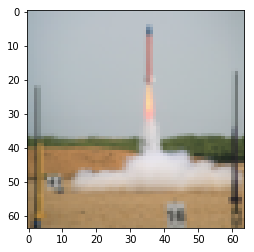

In [3]:
index = 22
plt.imshow(train_set_x_orig[index])
#print("train_set_y=" + str(train_set_y))  查看训练集里的标签

打印出当前的训练标签值

使用np.squeeze的目的是压缩维度，[未压缩]train_set_y[:,index]的值为[1]，[压缩后]np.squeeze(train_set_y[:,index])的值为1

print("[使用np.squeeze：" + str(np.squeeze(train_set_y[:,index])) + "，不使用np.squeeze： " + str(train_set_y[:,index]) + "]")

只有压缩后的值才能进行解码操作

In [4]:
print("y=" + str(train_set_y[:,index]) + ",it's a " + classes[np.squeeze(train_set_y[:,index])].decode("utf-8") + "' picture")

y=[0],it's a non-cat' picture


m_train ：训练集里图片的数量。

m_test ：测试集里图片的数量。

num_px ： 训练、测试集里面的图片的宽度和高度（均为64x64）。

train_set_x_orig 是一个维度为(m_​​train，num_px，num_px，3）的数组。

In [5]:
m_train = train_set_y.shape[1] #训练集里图片的数量。
m_test = test_set_y.shape[1] #测试集里图片的数量。
num_px = train_set_x_orig.shape[1] #训练、测试集里面的图片的宽度和高度（均为64x64）。

#输出看结果
print("训练集的数量 : m_train = " + str(m_train))
print("测试集的数量 : m_test = " + str(m_test))
print("每张图片的宽/高 : num_px = " + str(num_px))
print("每张图片的大小 : (" + str(num_px) + ", " + str(num_px) + ", 3)")
print("训练集_图片的维数 : " + str(train_set_x_orig.shape))
print("训练集_标签的维数 : " + str(train_set_y.shape))
print("测试集_图片的维数 : " + str(test_set_x_orig.shape))
print("测试集_标签的维数 : " + str(test_set_y.shape))

训练集的数量 : m_train = 209
测试集的数量 : m_test = 50
每张图片的宽/高 : num_px = 64
每张图片的大小 : (64, 64, 3)
训练集_图片的维数 : (209, 64, 64, 3)
训练集_标签的维数 : (1, 209)
测试集_图片的维数 : (50, 64, 64, 3)
测试集_标签的维数 : (1, 50)


为了方便，我们要把维度为（64，64，3）的numpy数组重新构造为（64 x 64 x 3，1）的数组，要乘以3的原因是每张图片是由64x64像素构成的，而每个像素点由（R，G，B）三原色构成的，所以要乘以3。在此之后，我们的训练和测试数据集是一个numpy数组，【每列代表一个平坦的图像】 ，应该有m_train和m_test列。

当你想将形状（a，b，c，d）的矩阵X平铺成形状（b * c * d，a）的矩阵X_flatten时，可以使用以下代码：

In [6]:
# X_flatten = X.shape(X.shape[0],-1).T 
#将训练集的维度降低并转置。
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
#将测试集的维度降低并转置。
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T

In [7]:
print ("训练集降维最后的维度： " + str(train_set_x_flatten.shape))
print ("训练集_标签的维数 : " + str(train_set_y.shape))
print ("测试集降维之后的维度: " + str(test_set_x_flatten.shape))
print ("测试集_标签的维数 : " + str(test_set_y.shape))

训练集降维最后的维度： (12288, 209)
训练集_标签的维数 : (1, 209)
测试集降维之后的维度: (12288, 50)
测试集_标签的维数 : (1, 50)


为了表示彩色图像，必须为每个像素指定红色，绿色和蓝色通道（RGB），因此像素值实际上是从0到255范围内的三个数字的向量。机器学习中一个常见的预处理步骤是对数据集进行居中和标准化，这意味着可以减去每个示例中整个numpy数组的平均值，然后将每个示例除以整个numpy数组的标准偏差。但对于图片数据集，它更简单，更方便，几乎可以将数据集的每一行除以255（像素通道的最大值），因为在RGB中不存在比255大的数据，所以我们可以放心的除以255，让标准化的数据位于[0,1]之间，现在标准化我们的数据集：

In [8]:
train_set_x = train_set_x_flatten / 255
test_set_x = test_set_x_flatten / 255

现在总算是把我们加载的数据弄完了，我们现在开始构建神经网络。

建立神经网络的主要步骤是： 
1. 定义模型结构（例如输入特征的数量） 
2. 初始化模型的参数 
3. 循环：
  
  3.1 计算当前损失（正向传播）

  3.2 计算当前梯度（反向传播）

  3.3 更新参数（梯度下降）

构建sigmoid(),需要使用sigmoid(w ^ T x + b)计算来做出预测。

In [9]:
def sigmoid(z):
    """
    参数:
        z - 任何大小的标量或numpy数组。
        
    返回：
        s - sigmoid(z)
    """
    s = 1 / (np.exp(-z) + 1)
    return s

测试一下sigmoid()，检查一下是否符合我们所需要的条件。

In [10]:
# test sigmoid()
print("===== test sigmoid =====")
print("sigmoid(0) = " + str(sigmoid(0)))
print("sigmoid(-1) = " + str(sigmoid(-1)))
print("sigmoid([1,2]) = " + str(sigmoid(np.array([1,2]))))

===== test sigmoid =====
sigmoid(0) = 0.5
sigmoid(-1) = 0.2689414213699951
sigmoid([1,2]) = [0.73105858 0.88079708]


现在就可以初始化参数w和b。

In [11]:
def initialize_with_zeros(dim):
    """
        此函数为w创建一个维度为（dim，1）的0向量，并将b初始化为0。

        参数：
            dim  - 我们想要的w矢量的大小（或者这种情况下的参数数量）

        返回：
            w  - 维度为（dim，1）的初始化向量。
            b  - 初始化的标量（对应于偏差）
    """
    w = np.zeros(shape = (dim,1))
    b = 0
    #使用assert来确保我要的数据是正确的
    assert(w.shape == (dim,1)) #w的维度是（dim,1）
    assert(isinstance(b,float) or isinstance(b,int)) #b的类型是float或者是int
    
    return(w , b)

初始化参数的函数已经构建好了，现在就可以执行“前向”和“后向”传播步骤来学习参数。

我们现在要实现一个计算成本函数及其渐变的函数propagate（）。

In [12]:
def propagate(w, b, X, Y):
    """
    实现前向和后向传播的成本函数及其梯度。
    参数：
        w  - 权重，大小不等的数组（num_px * num_px * 3，1）
        b  - 偏差，一个标量
        X  - 矩阵类型为（num_px * num_px * 3，训练数量）
        Y  - 真正的“标签”矢量（如果非猫则为0，如果是猫则为1），矩阵维度为(1,训练数据数量)

    返回：
        cost- 逻辑回归的负对数似然成本
        dw  - 相对于w的损失梯度，因此与w相同的形状
        db  - 相对于b的损失梯度，因此与b的形状相同
    """
    m = X.shape[1]
    
    #正向传播
    A = sigmoid(np.dot(w.T,X) + b) #计算激活值 
    cost = (-1 / m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1-A))) #计算成本
    
    #反向传播
    dw = (1 / m) * np.dot(X,(A - Y).T)
    db = (1 / m) * np.sum(A - Y)
    
    #使用断言确保我的数据是正确的
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    #creat a dictionary to store dw and db
    grads = {
                "dw": dw,
                "db": db
            }
    return (grads , cost)

测试一下

In [13]:
#测试一下propagate
print("====================测试propagate====================")
#初始化一些参数
w, b, X, Y = np.array([[1], [2]]), 2, np.array([[1,2], [3,4]]), np.array([[1, 0]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

====================测试propagate====================
dw = [[0.99993216]
 [1.99980262]]
db = 0.49993523062470574
cost = 6.000064773192205


使用梯度下降更新参数

目标是通过最小化成本函数$J$来学习$\omega$和$b$。对于参数$\theta$，更新规则是$\theta=θ−α dθ$ 

In [14]:
def optimize(w , b , X , Y , num_iterations , learning_rate , print_cost = False):
    """
    此函数通过运行梯度下降算法来优化w和b

    参数：
        w  - 权重，大小不等的数组（num_px * num_px * 3，1）
        b  - 偏差，一个标量
        X  - 维度为（num_px * num_px * 3，训练数据的数量）的数组。
        Y  - 真正的“标签”矢量（如果非猫则为0，如果是猫则为1），矩阵维度为(1,训练数据的数量)
        num_iterations  - 优化循环的迭代次数
        learning_rate  - 梯度下降更新规则的学习率
        print_cost  - 每100步打印一次损失值

    返回：
        params  - 包含权重w和偏差b的字典
        grads  - 包含权重和偏差相对于成本函数的梯度的字典
        成本 - 优化期间计算的所有成本列表，将用于绘制学习曲线。

    提示：
    我们需要写下两个步骤并遍历它们：
        1）计算当前参数的成本和梯度，使用propagate（）。
        2）使用w和b的梯度下降法则更新参数。
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        grads, cost = propagate(w, b, X, Y)
        
        dw = grads["dw"]
        db = grads["db"]
        
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        #record cost
        if i % 100 == 0:
            costs.append(cost)
        #print cost data
        if (print_cost) and (i % 100 == 0):
            print("迭代的次数: % i , 误差值: %f" % (i,cost))
            
    params = {
                "w" : w,
                "b" : b }
    grads = {
                "dw" : dw,
                "db" : db }
    return(params , grads , costs)

In [15]:
#test optimize
print("===== test optimize =====")
w, b, X, Y = np.array([[1],[2]]), 2, np.array([[1,2],[3,4]]), np.array([[1,0]])
params , grads , costs = optimize(w , b , X , Y , num_iterations = 100 , learning_rate = 0.09 , print_cost = False)
print("w = " + str(params["w"]))
print("b = " + str(params["b"]))
print("dw = " + str(grads["dw"]))
print("db = " + str(grads["db"]))

===== test optimize =====
w = [[-0.98778642]
 [-0.19158085]]
b = 1.8981027842897988
dw = [[ 0.09247419]
 [-0.02390367]]
db = -0.05818892715848467


optimize函数会输出已学习的w和b的值，我们可以使用w和b来预测数据集X的标签。

现在我们要实现预测函数$predict（）$。计算预测有两个步骤：

计算 $Y^=A=σ(wTX+b)Y^=A=σ(wTX+b) $
将$a$的值变为0（如果激活值$<= 0.5$）或者为1（如果激活值$> 0.5$），

然后将预测值存储在向量$Y_prediction$中。

In [16]:
def predict(w , b , X):
    """
    使用学习逻辑回归参数logistic （w，b）预测标签是0还是1，

    参数：
        w  - 权重，大小不等的数组（num_px * num_px * 3，1）
        b  - 偏差，一个标量
        X  - 维度为（num_px * num_px * 3，训练数据的数量）的数据

    返回：
        Y_prediction  - 包含X中所有图片的所有预测【0 | 1】的一个numpy数组（向量）

    """
    
    m = X.shape[1]#number of images
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0],1)
    
    #计预测猫在图片中出现的概率
    
    A = sigmoid(np.dot(w.T,X) + b)
    for i in range(A.shape[1]):
        
        #将概率a[0,i]转换为实际预测p[0,i]
        
        Y_prediction[0,i] = 1 if A[0,i] > 0.5 else 0
        
    #使用断言
    
    assert(Y_prediction.shape == (1,m))
    
    return Y_prediction

In [17]:
#test prediction
print("===== test prediction =====")
w, b, X, Y = np.array([[1],[2]]),2,np.array([[1,2],[3,4]]),np.array([[1,0]])
print("predictions = " + str(predict(w , b , X)))

===== test prediction =====
predictions = [[1. 1.]]


In [18]:
def model(X_train , Y_train , X_test , Y_test , num_iterations = 2000 , learning_rate = 0.5 , print_cost = False):
    """
    通过调用之前实现的函数来构建逻辑回归模型

    参数：
        X_train  - numpy的数组,维度为（num_px * num_px * 3，m_train）的训练集
        Y_train  - numpy的数组,维度为（1，m_train）（矢量）的训练标签集
        X_test   - numpy的数组,维度为（num_px * num_px * 3，m_test）的测试集
        Y_test   - numpy的数组,维度为（1，m_test）的（向量）的测试标签集
        num_iterations  - 表示用于优化参数的迭代次数的超参数
        learning_rate  - 表示optimize（）更新规则中使用的学习速率的超参数
        print_cost  - 设置为true以每100次迭代打印成本

    返回：
        d  - 包含有关模型信息的字典。
    """
    w , b = initialize_with_zeros(X_train.shape[0])
    
    parameters , grads , costs = optimize(w , b , X_train , Y_train , num_iterations , learning_rate , print_cost)
    
    #find parameters w and b from dict.params
    w , b = parameters["w"] , parameters["b"]
    
    #预测测试/训练集的例子
    Y_prediction_test = predict(w , b , X_test)
    Y_prediction_train = predict(w , b , X_train)
    
    #打印训练后的准确性
    print("训练集的准确性: " , format(100 - np.mean(np.abs(Y_prediction_train - Y_train))*100),"%")
    print("测试集的准确性: " , format(100 - np.mean(np.abs(Y_prediction_test - Y_test))*100),"%")
    
    d = {
            "costs" : costs,
            "Y_prediction_test" : Y_prediction_test,
            "Y_prediction_train" : Y_prediction_train,
            "w" : w,
            "b" : b,
            "learning_rate" : learning_rate,
            "num_iterations" : num_iterations }
    return d

In [19]:
print("===== test model =====")
#此处加载真实数据
d = model(train_set_x , train_set_y , test_set_x , test_set_y , num_iterations = 2000 , learning_rate = 0.005 , print_cost = True)

===== test model =====
迭代的次数:  0 , 误差值: 0.693147
迭代的次数:  100 , 误差值: 0.584508
迭代的次数:  200 , 误差值: 0.466949
迭代的次数:  300 , 误差值: 0.376007
迭代的次数:  400 , 误差值: 0.331463
迭代的次数:  500 , 误差值: 0.303273
迭代的次数:  600 , 误差值: 0.279880
迭代的次数:  700 , 误差值: 0.260042
迭代的次数:  800 , 误差值: 0.242941
迭代的次数:  900 , 误差值: 0.228004
迭代的次数:  1000 , 误差值: 0.214820
迭代的次数:  1100 , 误差值: 0.203078
迭代的次数:  1200 , 误差值: 0.192544
迭代的次数:  1300 , 误差值: 0.183033
迭代的次数:  1400 , 误差值: 0.174399
迭代的次数:  1500 , 误差值: 0.166521
迭代的次数:  1600 , 误差值: 0.159305
迭代的次数:  1700 , 误差值: 0.152667
迭代的次数:  1800 , 误差值: 0.146542
迭代的次数:  1900 , 误差值: 0.140872
训练集的准确性:  99.04306220095694 %
测试集的准确性:  70.0 %


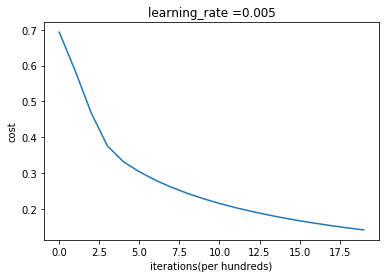

In [20]:
#绘制图
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations(per hundreds)')
plt.title("learning_rate =" + str(d["learning_rate"]))
plt.show()

让我们进一步分析一下，并研究学习率$\alpha$的可能选择。为了让渐变下降起作用，我们必须明智地选择学习速率。学习率$\alpha$ 决定了我们更新参数的速度。如果学习率过高，我们可能会“超过”最优值。同样，如果它太小，我们将需要太多迭代才能收敛到最佳值。这就是为什么使用良好调整的学习率至关重要的原因。

我们可以比较一下我们模型的学习曲线和几种学习速率的选择。也可以尝试使用不同于我们初始化的$learning\_rates$变量包含的三个值，并看一下会发生什么。

learning rate is: 0.01
训练集的准确性:  99.52153110047847 %
测试集的准确性:  68.0 %

--------------------------------------------

learning rate is: 0.001
训练集的准确性:  88.99521531100478 %
测试集的准确性:  64.0 %

--------------------------------------------

learning rate is: 0.0001
训练集的准确性:  68.42105263157895 %
测试集的准确性:  36.0 %

--------------------------------------------



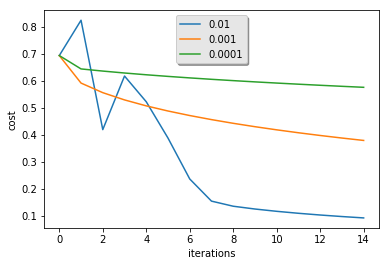

In [23]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print('\n' + "--------------------------------------------" + '\n')
    
for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label = str(models[str(i)]["learning_rate"]))
    
plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc = 'upper center', shadow = True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()